In [12]:
import os
import sys
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from collections import Counter, defaultdict
from utils import show_image

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.backend as K
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix
from object_detection.utils import label_map_util

In [27]:
def gridSearchOptimize(mdlname, verbose=True):
    if not os.path.exists('../models/{}'.format(mdlname)):
        os.mkdir('../models/{}'.format(mdlname))
        
    K.clear_session() # Clear any previous session!
    iteration = 1
    res = []

    # Hyperparams
    batch_sizes = [8, 16]
    optimizers = [RMSprop, Adam, SGD]
    learn_rates = [0.001, 0.01, 0.1]    
    dropouts = [0, 0.1, 0.2]
    label_smoothening = [0, 0.1, 0.2]
    regularizers = [l1, l2]
    regularizer_values = [0.0001, 0.001]
    allow_training = [False, True]
    start_time = time.time()
    iteration_time = time.time()

    print("Started hyperparameter tuning...")
    for batchSize in batch_sizes:
        for optimizer in optimizers:
            for learnRate in learn_rates:
                for dropOutRate in dropouts:
                    for lblSmooth in label_smoothening:
                        for reg in regularizers:
                            for regVal in regularizer_values:
                                for allowTuning in allow_training:
                                    loop_time = time.time()
                                    loss, acc = np.random.rand(), np.random.rand()
                                    res.append([
                                        loss, acc, batchSize, optimizer, learnRate, dropOutRate, lblSmooth, reg, regVal, allowTuning
                                    ])
                                    if verbose and ((iteration % 8) == 0):
                                        print(iteration, "Processed ---> {:.3f} LOSS, {:.3f} ACCU (this {:.4f} sec, overall {:.4f} sec)".format(loss, acc, (time.time() - loop_time), (time.time() - iteration_time)))
                                        iteration_time = time.time()
                                    iteration += 1
                                    K.clear_session() # Clear memory used. Proceed to next!

    end_time = time.time()
    print("Finished hyperparameter tuning, time elapsed: {:.4f} sec.".format((end_time - start_time)))

    if len(res) == 0:
        print("No results were recorded?!")
        return

    res.sort(key = lambda x: x[0]) # Sort on LOSS, low->high
    print("Writing results to ../models/{}/stat.csv".format(mdlname))
    with open('../models/{}/stat.csv'.format(mdlname), 'w') as f:
        for obj in res:
            s = ','.join([str(v) for v in obj])
            f.write('{}\n'.format(s))

    print("Finished hyperparameter tuning!")

In [29]:
gridSearchOptimize('test')

Started hyperparameter tuning...
8 Processed ---> 0.020 LOSS, 0.496 ACCU (this 0.0000 sec, overall 0.0120 sec)
16 Processed ---> 0.032 LOSS, 0.344 ACCU (this 0.0000 sec, overall 0.0140 sec)
24 Processed ---> 0.381 LOSS, 0.770 ACCU (this 0.0000 sec, overall 0.0130 sec)
32 Processed ---> 0.957 LOSS, 0.889 ACCU (this 0.0000 sec, overall 0.0140 sec)
40 Processed ---> 0.879 LOSS, 0.051 ACCU (this 0.0000 sec, overall 0.0130 sec)
48 Processed ---> 0.021 LOSS, 0.715 ACCU (this 0.0000 sec, overall 0.0120 sec)
56 Processed ---> 0.510 LOSS, 0.260 ACCU (this 0.0000 sec, overall 0.0130 sec)
64 Processed ---> 0.577 LOSS, 0.574 ACCU (this 0.0000 sec, overall 0.0130 sec)
72 Processed ---> 0.230 LOSS, 0.644 ACCU (this 0.0000 sec, overall 0.0120 sec)
80 Processed ---> 0.987 LOSS, 0.771 ACCU (this 0.0000 sec, overall 0.0130 sec)
88 Processed ---> 0.205 LOSS, 0.511 ACCU (this 0.0000 sec, overall 0.0120 sec)
96 Processed ---> 0.852 LOSS, 0.646 ACCU (this 0.0000 sec, overall 0.0130 sec)
104 Processed ---> 0

848 Processed ---> 0.558 LOSS, 0.723 ACCU (this 0.0000 sec, overall 0.0130 sec)
856 Processed ---> 0.319 LOSS, 0.356 ACCU (this 0.0000 sec, overall 0.0120 sec)
864 Processed ---> 0.733 LOSS, 0.453 ACCU (this 0.0000 sec, overall 0.0130 sec)
872 Processed ---> 0.265 LOSS, 0.235 ACCU (this 0.0000 sec, overall 0.0130 sec)
880 Processed ---> 0.655 LOSS, 0.232 ACCU (this 0.0000 sec, overall 0.0130 sec)
888 Processed ---> 0.610 LOSS, 0.084 ACCU (this 0.0000 sec, overall 0.0120 sec)
896 Processed ---> 0.220 LOSS, 0.597 ACCU (this 0.0000 sec, overall 0.0120 sec)
904 Processed ---> 0.422 LOSS, 0.659 ACCU (this 0.0000 sec, overall 0.0130 sec)
912 Processed ---> 0.829 LOSS, 0.650 ACCU (this 0.0000 sec, overall 0.0130 sec)
920 Processed ---> 0.953 LOSS, 0.020 ACCU (this 0.0000 sec, overall 0.0120 sec)
928 Processed ---> 0.799 LOSS, 0.487 ACCU (this 0.0000 sec, overall 0.0130 sec)
936 Processed ---> 0.341 LOSS, 0.607 ACCU (this 0.0000 sec, overall 0.0130 sec)
944 Processed ---> 0.334 LOSS, 0.705 ACC

In [40]:
def createDF(data):
    data = np.array(data)    
    df = pd.DataFrame()
    cols = ['Loss', 'Acc', 'BatchSize', 'Optimizer', 'LearnRate', 'DropOut', 'LabelSmooth', 'Regularizer', 'RegValue', 'AllowTune']
    for i,v in enumerate(cols):
        df[v] = data[:,i]
    return df

In [41]:
content = []
with open('../models/mobilenet_fast/stat.csv', 'r') as f:
    for line in f:
        line = line.strip().lower()
        line = line.replace('tensorflow.python.keras.optimizer_v2.gradient_descent.', '').replace('tensorflow.python.keras.regularizers.', '')
        line = line.split(',')
        line[0], line[1] = float('{:.5f}'.format(float(line[0]))), float('{:.5f}'.format(float(line[1])))
        content.append(line)

In [44]:
content.sort(key=lambda x: x[1], reverse=True)
df1 = createDF(content[:10])
df1

Loss      Acc BatchSize      Optimizer LearnRate DropOut LabelSmooth  \
0  1.03656  0.68918        16  <class 'sgd'>     0.001       0           0   
1  1.09448  0.66683        16  <class 'sgd'>     0.001     0.2           0   
2  0.86586  0.65392        16  <class 'sgd'>     0.001     0.2           0   
3  1.06023  0.64945        16  <class 'sgd'>     0.001     0.1           0   
4  0.86956  0.64499        16  <class 'sgd'>     0.001       0           0   
5  0.88838    0.643        16  <class 'sgd'>     0.001       0           0   
6  0.88584  0.63505        16  <class 'sgd'>     0.001       0           0   
7  0.90844  0.62959        16  <class 'sgd'>     0.001     0.1           0   
8  0.92296  0.61718        16  <class 'sgd'>     0.001     0.2           0   
9  0.97155  0.61668        16  <class 'sgd'>     0.001     0.2           0   

    Regularizer RegValue AllowTune  
0  <class 'l1'>    0.001     false  
1  <class 'l1'>    0.001     false  
2  <class 'l2'>   0.0001     false  
3  <class 'l1'>    0.001     false  
4  <class 'l2'>    0.001     false  
5  <class 'l1'>   0.0001     false  
6  <class 'l2'>   0.0001     false  
7  <class 'l2'>    0.001     false  
8  <class 'l1'>   0.0001     false  
9  <class 'l2'>    0.001     false

In [45]:
content.sort(key=lambda x: x[0], reverse=False)
df2 = createDF(content[:10])
df2

Loss      Acc BatchSize      Optimizer LearnRate DropOut LabelSmooth  \
0  0.86586  0.65392        16  <class 'sgd'>     0.001     0.2           0   
1  0.86956  0.64499        16  <class 'sgd'>     0.001       0           0   
2  0.88584  0.63505        16  <class 'sgd'>     0.001       0           0   
3  0.88838    0.643        16  <class 'sgd'>     0.001       0           0   
4  0.90844  0.62959        16  <class 'sgd'>     0.001     0.1           0   
5  0.92296  0.61718        16  <class 'sgd'>     0.001     0.2           0   
6  0.92391   0.6137        16  <class 'sgd'>     0.001     0.1           0   
7  0.95092  0.60427        16  <class 'sgd'>     0.001     0.1           0   
8  0.97155  0.61668        16  <class 'sgd'>     0.001     0.2           0   
9  1.03656  0.68918        16  <class 'sgd'>     0.001       0           0   

    Regularizer RegValue AllowTune  
0  <class 'l2'>   0.0001     false  
1  <class 'l2'>    0.001     false  
2  <class 'l2'>   0.0001     false  
3  <class 'l1'>   0.0001     false  
4  <class 'l2'>    0.001     false  
5  <class 'l1'>   0.0001     false  
6  <class 'l2'>   0.0001     false  
7  <class 'l1'>   0.0001     false  
8  <class 'l2'>    0.001     false  
9  <class 'l1'>    0.001     false

In [13]:
BATCH = 16
TARGET_SIZE = (224, 224)

In [30]:
train = ImageDataGenerator(
    rescale = 1.0/255.0, 
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True,
    brightness_range = [0.2, 1.0]
)

test = ImageDataGenerator(
    rescale = 1.0/255.0
)

train_gen = train.flow_from_directory(
    "../images/train/", 
    color_mode="rgb", 
    batch_size = BATCH, 
    class_mode="categorical", 
    target_size = TARGET_SIZE, 
    interpolation="bilinear",
    shuffle=True
)

test_gen = test.flow_from_directory(
    "../images/test/", 
    color_mode="rgb", 
    batch_size = 1, 
    class_mode="categorical", 
    target_size = TARGET_SIZE, 
    interpolation="bilinear",
    shuffle=True
)

Found 18288 images belonging to 5 classes.
Found 2014 images belonging to 5 classes.


In [235]:
other = ImageDataGenerator(
    rescale = 1.0/255.0, 
    rotation_range = 30, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True,
    brightness_range = [0.2, 1.0]
)

In [111]:
I = cv2.imread('../images/test/car/kitti_001261_1.jpg')
aug = other.flow(np.expand_dims(I,0), batch_size=1)

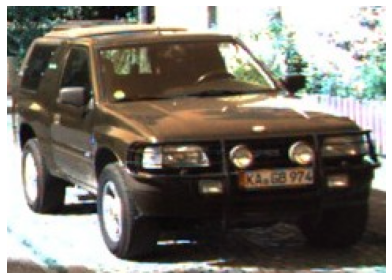

In [112]:
show_image(I, size=(6,4))

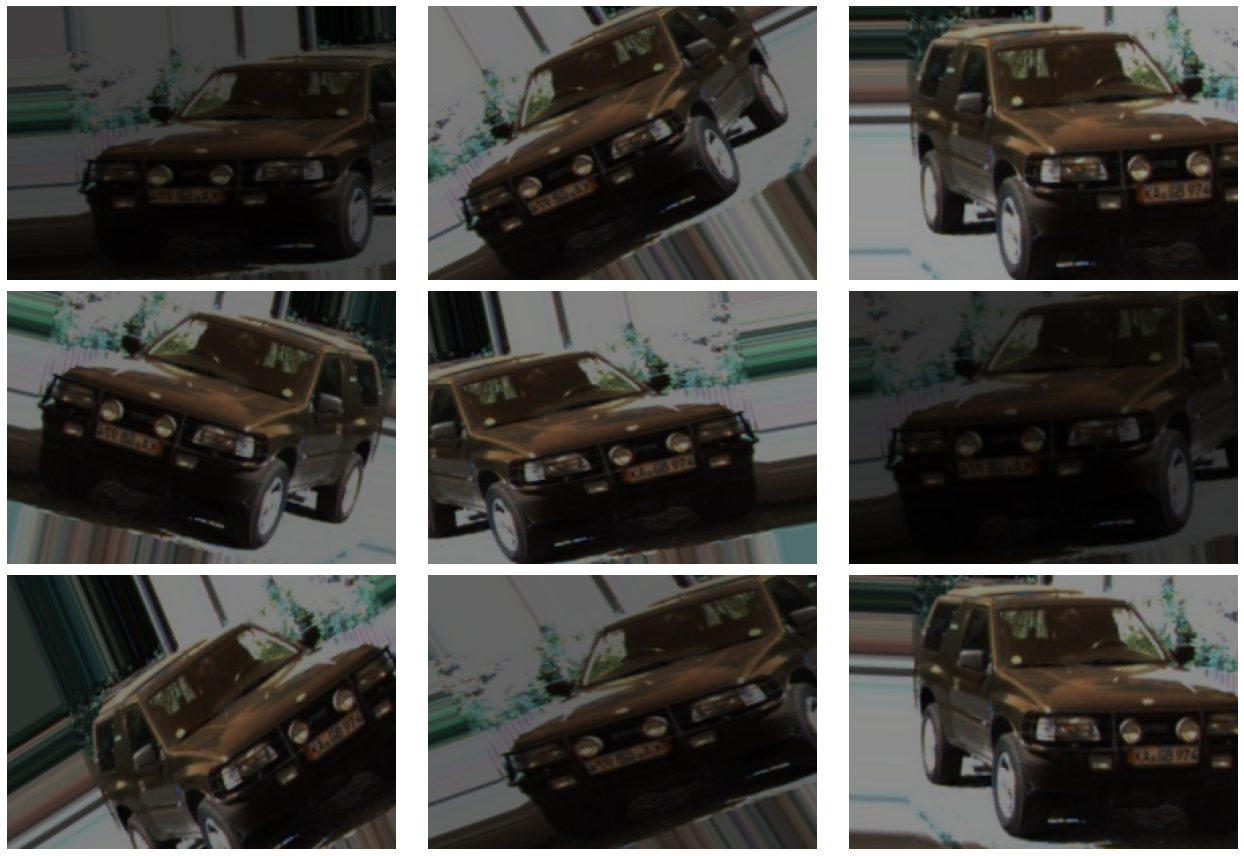

In [113]:
plt.figure(figsize=(6*3,4*3))
for i in range(9):
    sample = (aug.next()[0]*255.0).astype('uint8')
    ax = plt.subplot(int('33{}'.format(i+1)))
    plt.imshow(sample)
    plt.xticks([]),plt.yticks([])
    ax.axis("off")    
plt.tight_layout()
#plt.savefig('../images/temp/{}.png'.format('augmentations'))
plt.show()

In [2]:
HUB_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5" # URL for feat. vec. (pre-trained mdl)

In [11]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(224,224,3)),
    hub.KerasLayer(HUB_URL, trainable=False),
    Dropout(rate=0.1),
    Dense(4000, activation='relu'),
    Dropout(rate=0.1),
    Dense(5, activation='softmax')
])
model.build((None,224,224,3))
model.summary()
model.compile(
    optimizer = Adam(learning_rate=0.001), 
    loss = CategoricalCrossentropy(from_logits=True, label_smoothing=0.1), 
    metrics = ['accuracy']
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 1280)              4226432   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 4000)              5124000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 4000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 20005     
Total params: 9,370,437
Trainable params: 5,144,005
Non-trainable params: 4,226,432
_________________________________________________________________


In [27]:
y =      np.array([0,1,1,0,0,1,1,0,0,1,1,0])
y_pred = np.array([1,1,0,0,1,0,0,1,0,0,0,1])

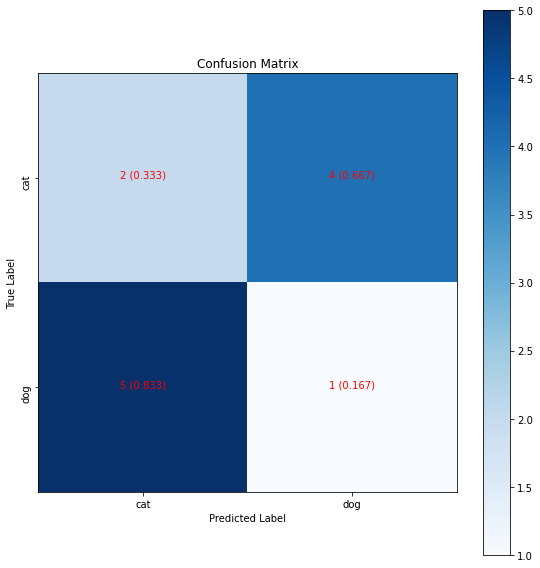

In [28]:
# Confusion Matrix
a = confusion_matrix(y, y_pred)
class_names = ['cat', 'dog']
tick_marks = np.arange(len(class_names))

fig = plt.figure(figsize=(8, 8))
plt.imshow(a, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names, rotation=90)

for r in range(len(class_names)):
    for c in range(len(class_names)):
        plt.text(c, r, '{} ({:.3f})'.format(a[r,c], (a[r,c]/a[r,:].sum())), horizontalalignment="center", color='red')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [236]:
from scipy.stats import bernoulli

In [238]:
class BalancedDataGenerator(tf.keras.utils.Sequence):
    """
    Give some classes less probability to be picked in a batch than others.
    Revert to pure random if none gets chosen.
    """
    def __init__(
        self,
        target_size=(224, 224), 
        batch_size=16,
        target_path="../images/train/",
        distribution=[0.5, 0.85, 0.30, 0.40, 0.75] # Determines the prob. here! (bike, bus, car, person, truck)
    ):
        self.batches = batch_size
        self.classes = sorted(['car', 'truck', 'bus', 'person', 'bike'])
        self.aug = ImageDataGenerator(
            rescale = 1.0/255.0, 
            rotation_range = 30, 
            width_shift_range = 0.2, 
            height_shift_range = 0.2, 
            shear_range = 0.2, 
            zoom_range = 0.2, 
            horizontal_flip = True,
            brightness_range = [0.2, 1.0]
        )
        self.generators = []
        self.num_samples = 0
        for c in self.classes:
            gen = self.aug.flow_from_directory(
                target_path, 
                color_mode="rgb", 
                batch_size=1, 
                class_mode="categorical", 
                target_size=target_size, 
                interpolation="bilinear",
                shuffle=True,
                classes=[c]
            )
            self.generators.append(gen)
            self.num_samples += gen.samples        
        self.length = (self.num_samples // self.batches)
        self.distr = np.array(distribution)
        self.distr_order = np.argsort(distribution)
        self.on_epoch_end()

    def __len__(self):
        return self.length

    #def __getitem__(self, index):
    def get(self):
        X, y = [], np.zeros((self.batches, len(self.classes)), dtype=np.float32)
        for b in range(self.batches):
            i = -1
            for idx in self.distr_order:                
                if bernoulli.rvs(p=self.distr[idx]):
                    i = idx                    
                    break
            
            if i == -1: # If we failed to select any class above, pick random. 50-50...
                i = np.random.randint(len(self.classes))                
                    
            img, _ = self.generators[i].next()
            y[b,idx] = 1.0
            X.append(img)

        return np.concatenate(X), y

    def on_epoch_end(self):
        pass # We do nothing, our generators does the 'hard' work.

In [239]:
gfx = BalancedDataGenerator()

Found 887 images belonging to 1 classes.
Found 688 images belonging to 1 classes.
Found 10860 images belonging to 1 classes.
Found 5259 images belonging to 1 classes.
Found 594 images belonging to 1 classes.


In [267]:
X, y = gfx.get()
y

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [268]:
X.shape

(16, 224, 224, 3)

In [269]:
y.shape

(16, 5)

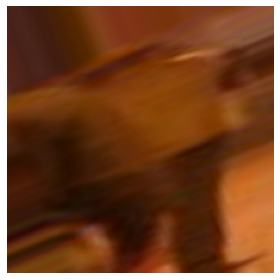

In [272]:
show_image((X[5]*255).astype(int), size=(6,4))

In [8]:
def show_eval_stat(file, folder='test'):
    class_data = []
    class_data_both = []
    class_dataset = []
    dataset = []
    sizes = [0,0]
    with open(file, 'r') as f:
        for line in f:
            line = line.strip().split(',')
            truth, pred, img = line[0], line[1], line[2].replace('\\', '/')
            sample = cv2.imread('../images/{}/{}'.format(folder,img))
            class_data.append(truth)
            class_data_both.append('{} - {}'.format(truth, pred))
            dataset.append(img.split('/')[-1].split('_')[0])
            class_dataset.append('{}: {} - {}'.format(dataset[-1], truth, pred))
            sizes[0] += sample.shape[1]
            sizes[1] += sample.shape[0]
            print(truth, '<->', pred)
            print(img, '-', sample.shape)
            show_image(sample, size=(4,2))            
    sizes[0] /= len(class_data)
    sizes[1] /= len(class_data)
    return Counter(class_data).most_common(), Counter(class_data_both).most_common(), Counter(dataset).most_common(), Counter(class_dataset).most_common(), sizes

bike <-> person
bike/dark_2015_01895_2.jpg - (33, 16, 3)


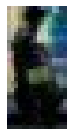

bike <-> person
bike/dark_2015_01895_3.jpg - (32, 20, 3)


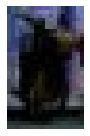

bike <-> person
bike/dark_2015_01895_4.jpg - (35, 16, 3)


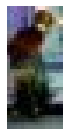

bike <-> person
bike/dark_2015_01895_5.jpg - (31, 28, 3)


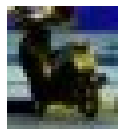

bike <-> car
bike/dark_2015_01992_1.jpg - (28, 23, 3)


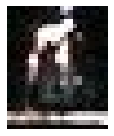

bike <-> person
bike/dark_2015_05761_0.jpg - (45, 29, 3)


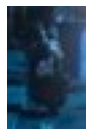

bike <-> person
bike/dark_2015_05806_4.jpg - (86, 71, 3)


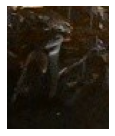

bike <-> person
bike/dark_2015_05956_15.jpg - (50, 36, 3)


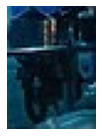

bike <-> car
bike/dark_2015_05974_0.jpg - (145, 167, 3)


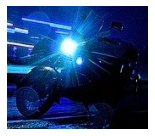

bike <-> car
bike/dark_2015_06013_10.jpg - (32, 21, 3)


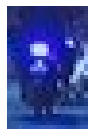

bike <-> person
bike/dark_2015_06013_12.jpg - (71, 39, 3)


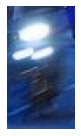

bike <-> person
bike/dark_2015_06061_2.jpg - (169, 126, 3)


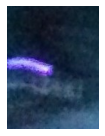

bike <-> car
bike/dark_2015_06061_3.jpg - (131, 136, 3)


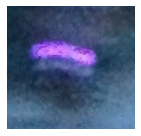

bike <-> person
bike/dark_2015_06066_0.jpg - (476, 446, 3)


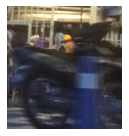

bike <-> person
bike/dark_2015_06066_1.jpg - (615, 545, 3)


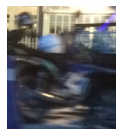

bike <-> person
bike/dark_2015_06066_2.jpg - (663, 1112, 3)


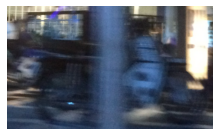

bike <-> car
bike/dark_2015_06080_1.jpg - (142, 131, 3)


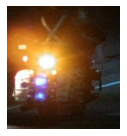

bike <-> person
bike/dark_2015_06172_11.jpg - (63, 58, 3)


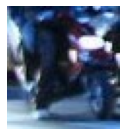

bike <-> car
bike/dark_2015_06172_12.jpg - (63, 50, 3)


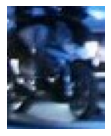

bike <-> person
bike/dark_2015_06209_0.jpg - (157, 87, 3)


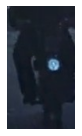

bike <-> car
bike/dark_2015_06209_2.jpg - (75, 65, 3)


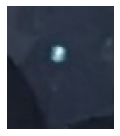

bike <-> person
bike/dark_2015_06235_3.jpg - (122, 112, 3)


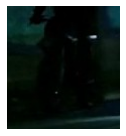

bus <-> person
bus/dark_2015_01888_0.jpg - (277, 405, 3)


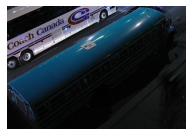

bus <-> car
bus/dark_2015_01926_0.jpg - (84, 64, 3)


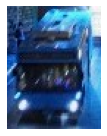

bus <-> car
bus/dark_2015_01929_0.jpg - (89, 152, 3)


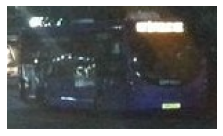

bus <-> car
bus/dark_2015_02185_1.jpg - (84, 48, 3)


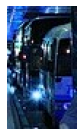

bus <-> car
bus/dark_2015_02250_0.jpg - (580, 1608, 3)


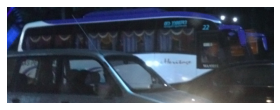

bus <-> car
bus/dark_2015_02385_0.jpg - (324, 295, 3)


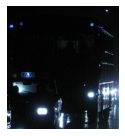

bus <-> car
bus/dark_2015_06354_2.jpg - (37, 40, 3)


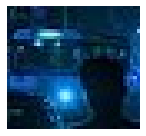

bus <-> car
bus/raw_e39_aug_n_08-01-00-40_0.jpg - (25, 28, 3)


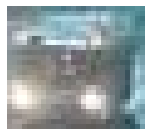

bus <-> truck
bus/raw_e39_aug_n_19-01-13-20_5.jpg - (21, 21, 3)


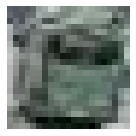

bus <-> car
bus/raw_e39_aug_s_06-01-18-07_3.jpg - (27, 28, 3)


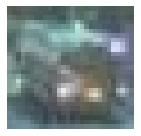

bus <-> truck
bus/raw_e39_aug_s_07-01-13-50_2.jpg - (21, 18, 3)


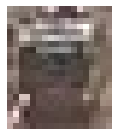

bus <-> truck
bus/raw_e39_aug_s_07-01-16-19_4.jpg - (11, 18, 3)


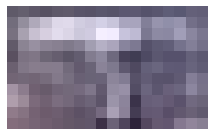

car <-> bus
car/dark_2015_01895_1.jpg - (48, 67, 3)


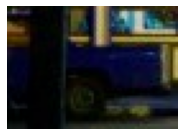

car <-> person
car/dark_2015_01926_4.jpg - (25, 52, 3)


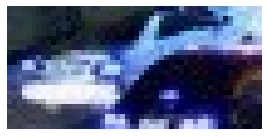

car <-> bus
car/dark_2015_02383_2.jpg - (204, 172, 3)


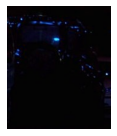

car <-> person
car/dark_2015_02385_3.jpg - (328, 126, 3)


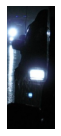

car <-> person
car/dark_2015_02427_0.jpg - (36, 65, 3)


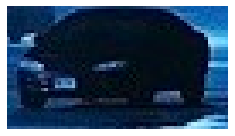

car <-> person
car/dark_2015_02427_1.jpg - (26, 45, 3)


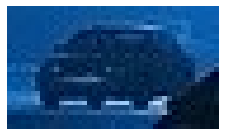

car <-> person
car/dark_2015_02427_3.jpg - (23, 37, 3)


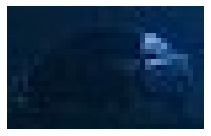

car <-> person
car/dark_2015_02427_4.jpg - (25, 35, 3)


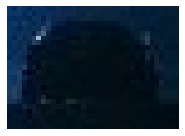

car <-> bike
car/dark_2015_02448_3.jpg - (130, 104, 3)


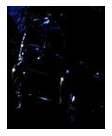

car <-> person
car/dark_2015_02477_2.jpg - (57, 81, 3)


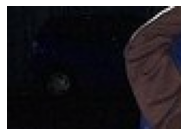

car <-> truck
car/dark_2015_02481_4.jpg - (21, 36, 3)


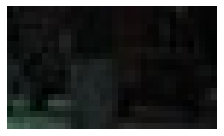

car <-> person
car/dark_2015_02539_0.jpg - (139, 222, 3)


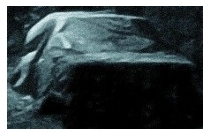

car <-> person
car/dark_2015_02546_3.jpg - (47, 43, 3)


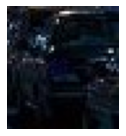

car <-> person
car/dark_2015_02546_4.jpg - (43, 41, 3)


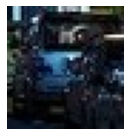

car <-> person
car/dark_2015_02546_5.jpg - (29, 33, 3)


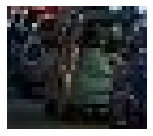

car <-> bike
car/dark_2015_02588_3.jpg - (26, 30, 3)


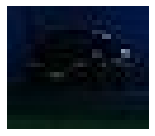

car <-> person
car/dark_2015_02588_4.jpg - (23, 27, 3)


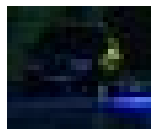

car <-> person
car/dark_2015_02590_2.jpg - (45, 51, 3)


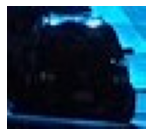

car <-> bike
car/dark_2015_02590_3.jpg - (56, 48, 3)


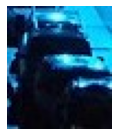

car <-> bus
car/dark_2015_02634_0.jpg - (277, 450, 3)


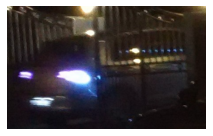

car <-> bike
car/dark_2015_02634_1.jpg - (230, 319, 3)


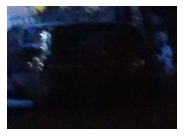

car <-> person
car/dark_2015_02638_0.jpg - (287, 415, 3)


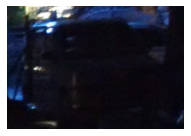

car <-> person
car/dark_2015_02638_1.jpg - (371, 410, 3)


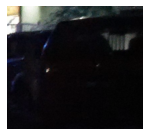

car <-> bus
car/dark_2015_02638_2.jpg - (603, 1288, 3)


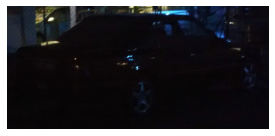

car <-> person
car/dark_2015_02642_2.jpg - (132, 298, 3)


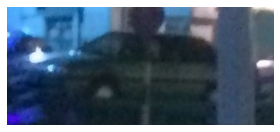

car <-> bike
car/dark_2015_02651_2.jpg - (364, 298, 3)


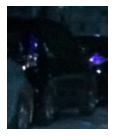

car <-> person
car/dark_2015_02658_0.jpg - (780, 1393, 3)


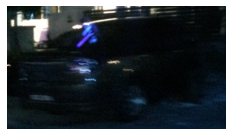

car <-> bike
car/dark_2015_02833_2.jpg - (75, 45, 3)


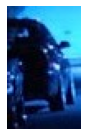

car <-> bike
car/dark_2015_02896_0.jpg - (169, 256, 3)


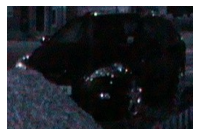

car <-> bike
car/dark_2015_02946_2.jpg - (54, 45, 3)


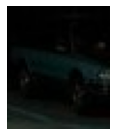

car <-> person
car/dark_2015_02962_2.jpg - (74, 179, 3)


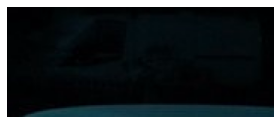

car <-> bike
car/dark_2015_02991_3.jpg - (52, 47, 3)


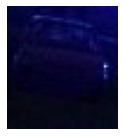

car <-> bike
car/dark_2015_02991_4.jpg - (152, 91, 3)


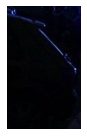

car <-> bus
car/dark_2015_03004_2.jpg - (409, 747, 3)


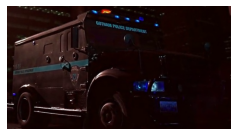

car <-> bike
car/dark_2015_06172_14.jpg - (67, 139, 3)


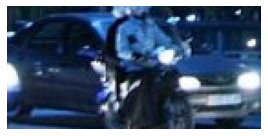

car <-> bike
car/dark_2015_06172_15.jpg - (78, 150, 3)


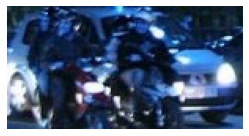

car <-> bike
car/dark_2015_06199_10.jpg - (212, 205, 3)


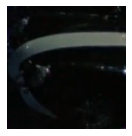

car <-> bike
car/dark_2015_06199_9.jpg - (350, 379, 3)


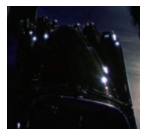

car <-> bus
car/dark_2015_06235_4.jpg - (238, 340, 3)


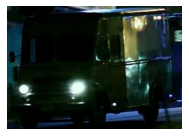

car <-> bus
car/dark_2015_06247_2.jpg - (39, 51, 3)


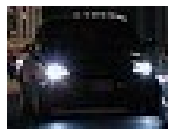

car <-> bike
car/dark_2015_06249_1.jpg - (53, 70, 3)


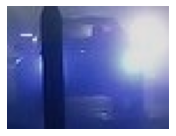

car <-> person
car/dark_2015_06354_0.jpg - (65, 70, 3)


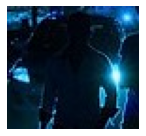

car <-> bike
car/dark_2015_06533_0.jpg - (164, 307, 3)


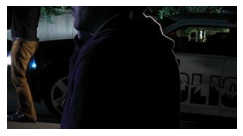

car <-> bike
car/dark_2015_06588_1.jpg - (100, 105, 3)


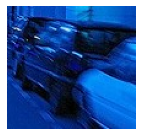

car <-> person
car/dark_2015_06588_2.jpg - (35, 37, 3)


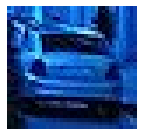

car <-> person
car/dark_2015_06692_0.jpg - (246, 272, 3)


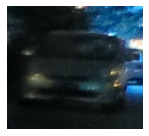

car <-> person
car/kitti_001442_1.jpg - (28, 38, 3)


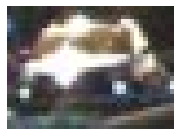

car <-> truck
car/kitti_001620_1.jpg - (21, 51, 3)


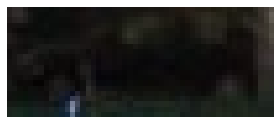

car <-> person
car/kitti_002514_0.jpg - (272, 32, 3)


car <-> person
car/kitti_005346_0.jpg - (175, 136, 3)


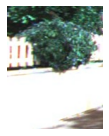

car <-> truck
car/kitti_005964_0.jpg - (29, 73, 3)


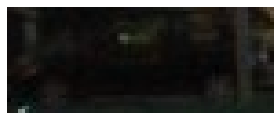

car <-> person
car/kitti_007045_0.jpg - (143, 54, 3)


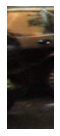

car <-> truck
car/raw_e39_aug_n_07-01-12-54_6.jpg - (14, 13, 3)


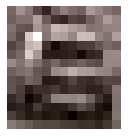

car <-> truck
car/raw_e39_aug_n_07-01-12-54_7.jpg - (22, 19, 3)


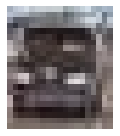

car <-> truck
car/raw_e39_aug_n_07-01-12-54_9.jpg - (19, 16, 3)


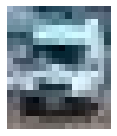

car <-> truck
car/raw_e39_aug_n_08-01-14-07_6.jpg - (11, 12, 3)


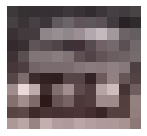

car <-> truck
car/raw_e39_aug_n_08-01-14-33_9.jpg - (13, 12, 3)


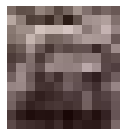

car <-> bike
car/raw_e39_aug_n_08-01-14-50_9.jpg - (21, 20, 3)


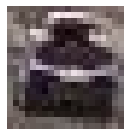

car <-> truck
car/raw_e39_aug_n_08-01-17-51_4.jpg - (15, 13, 3)


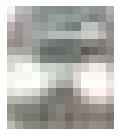

car <-> truck
car/raw_e39_aug_n_08-01-21-52_3.jpg - (14, 16, 3)


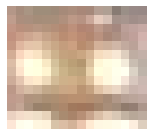

car <-> truck
car/raw_e39_aug_s_07-01-12-50_3.jpg - (12, 11, 3)


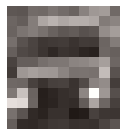

car <-> truck
car/raw_e39_aug_s_07-01-15-22_13.jpg - (17, 14, 3)


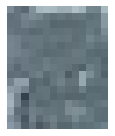

car <-> truck
car/raw_e39_aug_s_07-01-15-22_14.jpg - (12, 13, 3)


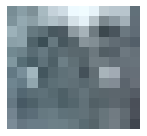

car <-> person
car/raw_e39_aug_s_07-01-16-19_1.jpg - (36, 39, 3)


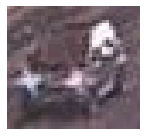

car <-> truck
car/raw_e39_aug_s_08-01-15-13_9.jpg - (11, 11, 3)


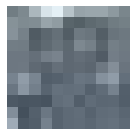

car <-> truck
car/raw_e39_aug_s_08-01-15-19_10.jpg - (13, 11, 3)


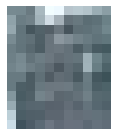

car <-> truck
car/raw_e39_aug_s_08-01-15-19_9.jpg - (12, 12, 3)


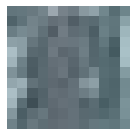

car <-> truck
car/raw_e39_aug_s_08-01-15-24_3.jpg - (22, 20, 3)


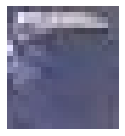

car <-> truck
car/raw_e39_aug_s_08-01-15-24_8.jpg - (17, 16, 3)


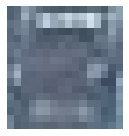

car <-> person
car/raw_e39_aug_s_08-01-16-41_0.jpg - (45, 56, 3)


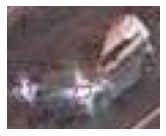

car <-> bike
car/raw_e39_aug_s_08-01-16-41_1.jpg - (30, 30, 3)


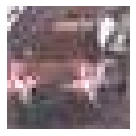

car <-> bike
car/raw_e39_vatland_08-01-21-16_0.jpg - (54, 76, 3)


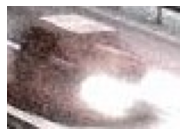

car <-> truck
car/raw_e6_nostvet_11-01-15-13_6.jpg - (19, 25, 3)


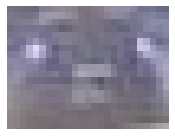

car <-> truck
car/raw_e6_nostvet_11-01-16-05_4.jpg - (17, 28, 3)


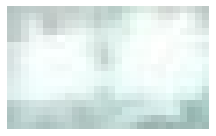

car <-> person
car/raw_e6_nostvet_11-01-17-46_0.jpg - (160, 248, 3)


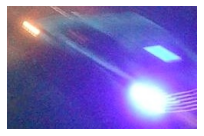

car <-> truck
car/raw_e6_nostvet_12-01-12-57_2.jpg - (28, 31, 3)


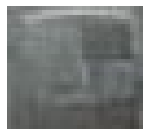

person <-> car
person/dark_2015_01895_6.jpg - (19, 18, 3)


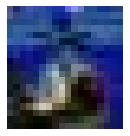

person <-> car
person/dark_2015_01902_1.jpg - (61, 33, 3)


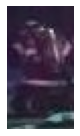

person <-> bike
person/dark_2015_01902_2.jpg - (62, 43, 3)


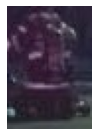

person <-> bike
person/dark_2015_02029_3.jpg - (92, 101, 3)


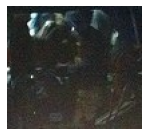

person <-> truck
person/dark_2015_02116_3.jpg - (36, 31, 3)


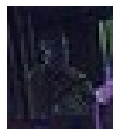

person <-> car
person/dark_2015_02116_5.jpg - (83, 37, 3)


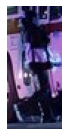

person <-> truck
person/dark_2015_02162_1.jpg - (18, 27, 3)


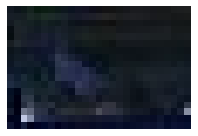

person <-> bike
person/dark_2015_02162_3.jpg - (25, 23, 3)


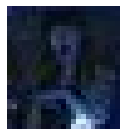

person <-> car
person/dark_2015_02209_3.jpg - (27, 53, 3)


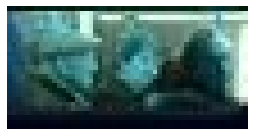

person <-> bike
person/dark_2015_02213_3.jpg - (50, 23, 3)


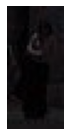

person <-> car
person/dark_2015_02313_2.jpg - (39, 24, 3)


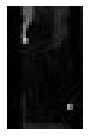

person <-> car
person/dark_2015_02383_3.jpg - (88, 82, 3)


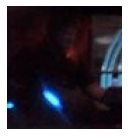

person <-> car
person/dark_2015_02546_6.jpg - (15, 12, 3)


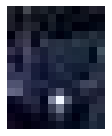

person <-> car
person/dark_2015_02705_1.jpg - (200, 84, 3)


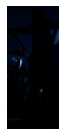

person <-> bike
person/dark_2015_05759_2.jpg - (540, 333, 3)


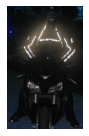

person <-> bike
person/dark_2015_05780_0.jpg - (467, 255, 3)


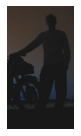

person <-> bike
person/dark_2015_05788_2.jpg - (54, 39, 3)


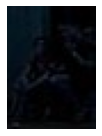

person <-> car
person/dark_2015_05806_0.jpg - (87, 37, 3)


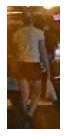

person <-> bike
person/dark_2015_05827_0.jpg - (132, 53, 3)


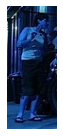

person <-> bike
person/dark_2015_05956_5.jpg - (26, 17, 3)


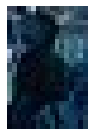

person <-> bike
person/dark_2015_05956_6.jpg - (22, 19, 3)


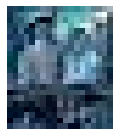

person <-> bike
person/dark_2015_06013_2.jpg - (41, 18, 3)


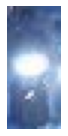

person <-> car
person/dark_2015_06013_6.jpg - (27, 21, 3)


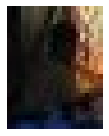

person <-> bike
person/dark_2015_06043_1.jpg - (195, 76, 3)


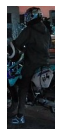

person <-> car
person/dark_2015_06080_0.jpg - (88, 63, 3)


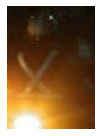

person <-> bike
person/dark_2015_06085_0.jpg - (210, 150, 3)


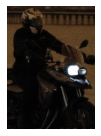

person <-> bike
person/dark_2015_06088_3.jpg - (433, 244, 3)


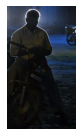

person <-> bike
person/dark_2015_06163_0.jpg - (371, 199, 3)


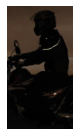

person <-> bike
person/dark_2015_06172_9.jpg - (72, 37, 3)


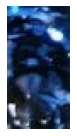

person <-> bike
person/dark_2015_06199_6.jpg - (164, 97, 3)


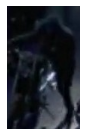

person <-> bike
person/dark_2015_06209_6.jpg - (86, 68, 3)


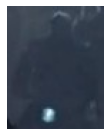

person <-> bike
person/dark_2015_06209_9.jpg - (182, 130, 3)


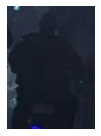

person <-> bike
person/dark_2015_06376_5.jpg - (94, 46, 3)


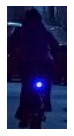

person <-> bike
person/dark_2015_06475_0.jpg - (735, 284, 3)


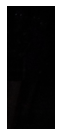

person <-> bike
person/dark_2015_06609_0.jpg - (258, 99, 3)


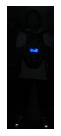

person <-> car
person/dark_2015_06683_0.jpg - (640, 662, 3)


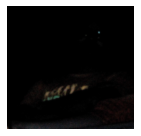

person <-> bike
person/dark_2015_06763_4.jpg - (175, 80, 3)


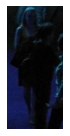

person <-> bike
person/dark_2015_06782_3.jpg - (298, 80, 3)


person <-> bike
person/dark_2015_06825_0.jpg - (378, 258, 3)


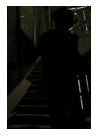

person <-> car
person/kitti_002699_1.jpg - (233, 237, 3)


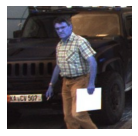

person <-> car
person/kitti_005482_1.jpg - (103, 48, 3)


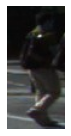

truck <-> person
truck/kitti_002513_0.jpg - (356, 132, 3)


truck <-> car
truck/raw_e39_aug_n_07-01-20-15_1.jpg - (28, 30, 3)


truck <-> car
truck/raw_e39_aug_n_08-01-00-19_0.jpg - (14, 13, 3)


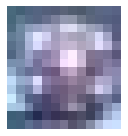

truck <-> car
truck/raw_rv150_ullevaal_18-01-14-01_5.jpg - (24, 19, 3)


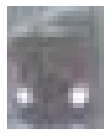

truck <-> car
truck/raw_rv150_ullevaal_18-01-17-59_0.jpg - (129, 147, 3)


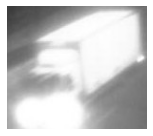

In [5]:
a, b, c, d, y = show_eval_stat('../logs/eval-25-04-11-56.txt')

In [6]:
a

[('car', 76), ('person', 41), ('bike', 22), ('bus', 12), ('truck', 5)]

In [7]:
b

[('car - person', 28),
 ('person - bike', 25),
 ('car - truck', 21),
 ('car - bike', 20),
 ('bike - person', 15),
 ('person - car', 14),
 ('bus - car', 8),
 ('bike - car', 7),
 ('car - bus', 7),
 ('truck - car', 4),
 ('bus - truck', 3),
 ('person - truck', 2),
 ('bus - person', 1),
 ('truck - person', 1)]

In [8]:
c

[('dark', 114), ('raw', 33), ('kitti', 9)]

In [10]:
d

[('dark: person - bike', 25),
 ('dark: car - person', 21),
 ('raw: car - truck', 18),
 ('dark: car - bike', 17),
 ('dark: bike - person', 15),
 ('dark: person - car', 12),
 ('dark: bike - car', 7),
 ('dark: car - bus', 7),
 ('dark: bus - car', 6),
 ('kitti: car - person', 4),
 ('raw: truck - car', 4),
 ('raw: bus - truck', 3),
 ('raw: car - bike', 3),
 ('raw: car - person', 3),
 ('raw: bus - car', 2),
 ('kitti: car - truck', 2),
 ('dark: person - truck', 2),
 ('kitti: person - car', 2),
 ('dark: bus - person', 1),
 ('dark: car - truck', 1),
 ('kitti: truck - person', 1)]

In [11]:
y # avg wide and tall

[137.87179487179486, 132.24358974358975]

bus <-> car
bus/raw_night_rv509_sommevaagen_26-04-05-35_1.jpg - (14, 13, 3)


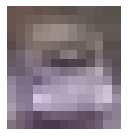

bus <-> truck
bus/raw_night_rv509_sommevaagen_26-04-06-16_0.jpg - (111, 152, 3)


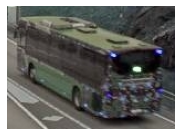

car <-> person
car/raw_night_rv509_sommevaagen_23-04-01-34_0.jpg - (27, 35, 3)


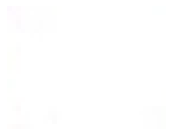

car <-> person
car/raw_night_rv509_sommevaagen_25-04-01-36_0.jpg - (20, 24, 3)


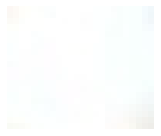

car <-> person
car/raw_night_rv509_sommevaagen_26-04-23-37_1.jpg - (28, 42, 3)


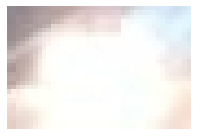

car <-> bike
car/raw_night_rv509_sommevaagen_27-04-06-57_1.jpg - (62, 64, 3)


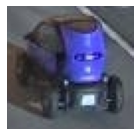

truck <-> person
truck/raw_night_rv509_sommevaagen_27-04-03-36_0.jpg - (194, 225, 3)


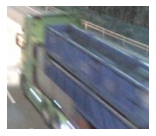

In [13]:
a, b, c, d, y = show_eval_stat('../logs/eval-27-04-10-22.txt', 'test_night')

In [17]:
b

[('car - person', 3),
 ('bus - car', 1),
 ('bus - truck', 1),
 ('car - bike', 1),
 ('truck - person', 1)]

In [18]:
y

[79.28571428571429, 65.14285714285714]

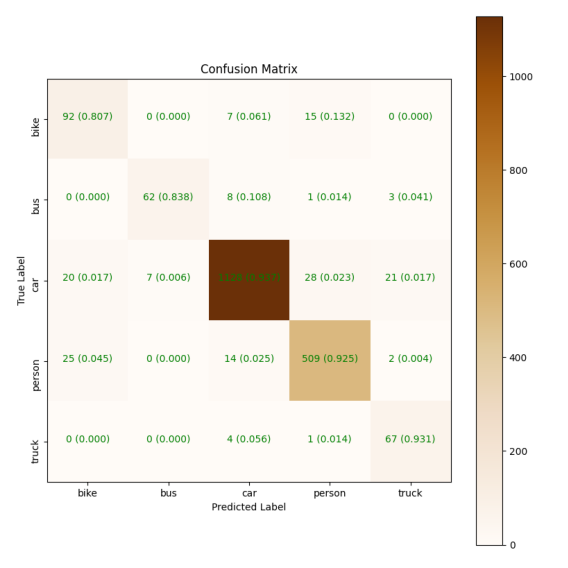

In [36]:
show_image(cv2.imread('../fig/mobilenet/plot_mobilenet_new_5_3.png'))

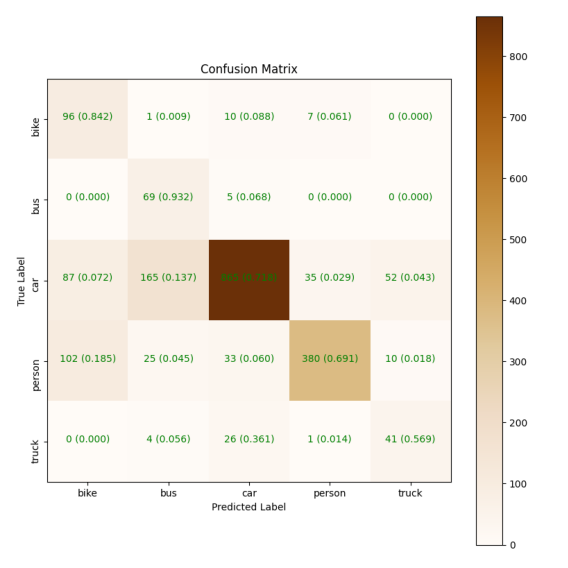

In [37]:
show_image(cv2.imread('../fig/mobilenet-fix/plot_mobilenet_small_2_3.png'))